In [1]:
import qpms
import numpy as np
from numpy import newaxis as nx
import math
import cmath
from scipy.constants import c, e as eV, hbar
s3 = math.sqrt(3)
J_scat = 3

In [2]:
def generate_trianglepoints(maxlayer, include_origin = False, v3d = True, circular = True):
    e6 = np.array([[math.cos(2*math.pi*i/6),math.sin(2*math.pi*i/6),0] if v3d else [math.cos(2*math.pi*i/6),math.sin(2*math.pi*i/6)] for i in range(6)])
    points = np.empty((3*maxlayer*(maxlayer+1)+(1 if include_origin else 0), 3 if v3d else 2))
    point_i = 0
    if (include_origin):
        points[0] = np.array((0,0,0) if v3d else (0,0))
        point_i = 1
    for layer in range(1,maxlayer+1):
        for i in range(6):
            base = e6[i]*layer
            shift = e6[(i+2)%6]
            for j in range(layer):
                points[point_i] = base + j*shift
                point_i += 1
    if (circular):
        points = points[np.sum(points * points, axis = -1) <= maxlayer * maxlayer * 3/ 4 + 0.1 ] # UGLY FIX OF ASYMMETRY BECAUSE OF ROUNDING ERROR
    return points

In [10]:
xxx = generate_trianglepoints(10, v3d=True, include_origin=False, circular = False)
#np.sum(xxx*xxx,axis=-1)
plt.plot(xxx[:,0], xxx[:,1], 'o')

In [4]:
epsilon_b = 2.3104
hexside = 375e-9
lMax = 3
maxlayer = 15
my, ny = qpms.get_mn_y(lMax)
nelem = len(my)

omega = 7124605395269800.0 # !!!
k_0 = omega * math.sqrt(epsilon_b) / c
bz_0 = np.array((0,0,0.,))
bz_K1 = np.array((1.,0,0))*4*np.pi/3/hexside/s3
bz_K2 = np.array((1./2.,s3/2,0))*4*np.pi/3/hexside/s3
bz_M = np.array((3./4, s3/4,0))*4*np.pi/3/hexside/s3

#Mie-type T-matrix
ω_p = 9*eV/hbar
ε_inf = 4.6
γ_p = 0.1*eV/hbar
part_radius = 50e-9
epsilon_i = qpms.ε_drude(ε_inf, ω_p, γ_p, omega)
k_i = cmath.sqrt(epsilon_i)*omega/c
RH, RV, TH, TV = qpms.mie_coefficients(a=part_radius, nmax=lMax, k_i=k_i, k_e=k_0, J_ext=1, J_scat=3)
TMatrices = np.zeros((2, 2, nelem, 2, nelem), dtype=complex)
for l in range(1, lMax+1):
  for m in range(-l, l+1): #demence
    TMatrices[0, 0, (ny == l) * (my == m), 0, (ny == l) * (my == m)] = RV[l]
    TMatrices[0, 1, (ny == l) * (my == m), 1, (ny == l) * (my == m)] = RH[l]
TMatrices[1] = TMatrices[0] # down same as up



unitcell_translations = hexside*s3*generate_trianglepoints(maxlayer, include_origin=False)
u2d_translation = -hexside*np.array((0,1,0))
u2d_translations_0 = hexside*(s3*generate_trianglepoints(maxlayer, include_origin=True))
d2u_translations_0 = u2d_translations_0
u2d_translations = u2d_translations_0 + u2d_translation
d2u_translations = d2u_translations_0 - u2d_translation

a_self = np.empty((unitcell_translations.shape[0],nelem, nelem), dtype=complex)
b_self = np.empty((unitcell_translations.shape[0],nelem, nelem), dtype=complex)
a_u2d = np.empty((u2d_translations.shape[0],nelem,nelem), dtype=complex)
b_u2d = np.empty((u2d_translations.shape[0],nelem,nelem), dtype=complex)
a_d2u = np.empty((u2d_translations.shape[0],nelem,nelem), dtype=complex)
b_d2u = np.empty((u2d_translations.shape[0],nelem,nelem), dtype=complex)

for j in range(a_self.shape[0]):
    d_i2j = qpms.cart2sph(unitcell_translations[j])
    for yi in range(nelem):
        for yj in range(nelem):
            a_self[j, yj, yi] = qpms.Ã(my[yj],ny[yj],my[yi],ny[yi],kdlj=d_i2j[0]*k_0,θlj=d_i2j[1],φlj=d_i2j[2],r_ge_d=False,J=J_scat)
            b_self[j, yj, yi] = qpms.B̃(my[yj],ny[yj],my[yi],ny[yi],kdlj=d_i2j[0]*k_0,θlj=d_i2j[1],φlj=d_i2j[2],r_ge_d=False,J=J_scat)
for j in range(a_u2d.shape[0]):
    d_i2j = qpms.cart2sph(u2d_translations[j])
    for yi in range(nelem):
        for yj in range(nelem):
            a_u2d[j, yj, yi] = qpms.Ã(my[yj],ny[yj],my[yi],ny[yi],kdlj=d_i2j[0]*k_0,θlj=d_i2j[1],φlj=d_i2j[2],r_ge_d=False,J=J_scat)
            b_u2d[j, yj, yi] = qpms.B̃(my[yj],ny[yj],my[yi],ny[yi],kdlj=d_i2j[0]*k_0,θlj=d_i2j[1],φlj=d_i2j[2],r_ge_d=False,J=J_scat)
for j in range(a_d2u.shape[0]):
    d_i2j = qpms.cart2sph(d2u_translations[j])
    for yi in range(nelem):
        for yj in range(nelem):
            a_d2u[j, yj, yi] = qpms.Ã(my[yj],ny[yj],my[yi],ny[yi],kdlj=d_i2j[0]*k_0,θlj=d_i2j[1],φlj=d_i2j[2],r_ge_d=False,J=J_scat)
            b_d2u[j, yj, yi] = qpms.B̃(my[yj],ny[yj],my[yi],ny[yi],kdlj=d_i2j[0]*k_0,θlj=d_i2j[1],φlj=d_i2j[2],r_ge_d=False,J=J_scat)



            
#-------------------------------------------

kdensity = 66
k0Mlist = bz_0 + (bz_M-bz_0) * np.linspace(0,1,kdensity)[:,nx]
kMK1list = bz_M + (bz_K1-bz_M) * np.linspace(0,1,kdensity)[:,nx]
kK10list = bz_K1 + (bz_0-bz_K1) * np.linspace(0,1,kdensity)[:,nx]
k0K2list = bz_0 + (bz_K2-bz_0) * np.linspace(0,1,kdensity)[:,nx]
kK2Mlist = bz_K2 + (bz_M-bz_K2) * np.linspace(0,1,kdensity)[:,nx]
klist = np.concatenate((k0Mlist,kMK1list,kK10list,k0K2list,kK2Mlist), axis=0)
kxmaplist = np.concatenate((np.array([0]),np.cumsum(np.linalg.norm(np.diff(klist, axis=0), axis=-1))))
#vlist = np.empty((klist.shape[0],2,2,nelem,2,2,nelem), dtype=complex)
wlist = np.empty((klist.shape[0],2,2,nelem), dtype=complex)
extlist = np.empty((klist.shape[0]))

# sem nějaká rozumná smyčka
for ki in range(klist.shape[0]):
    k = klist[ki]
    kz = math.sqrt(k_0*k_0 - k[0]*k[0] - k[1]*k[1])
    k3d_cart = np.array([k[0], k[1], kz])
    #k3d_sph = qpms.cart2sph(k3d_cart)
    E_0_cart = np.array((0,-1.,0)) # y-pol., not normalized
    
    
    #---- zde nastavit budicí 
    #p_y0, q_y0 = plane_pq_y(lMax, k3d_cart, E_0)
    P_0 = np.empty((2,2, nelem), dtype=complex)
    P_0[0,0], P_0[0,1] = qpms.plane_pq_y(lMax, k3d_cart, E_0_cart)
    P_0[1] = P_0[0] * np.exp(1j*np.dot(k3d_cart, u2d_translation ))
    excit = np.zeros((2,2,nelem), dtype=complex)
    for subl in (0,1):
        excit[subl] = np.tensordot(TMatrices[subl], P_0[subl], axes = [(-2,-1),(0,1)])

    

    phases_self = np.exp(1j*np.tensordot(k,unitcell_translations,axes=(0,-1)))
    phases_u2d = np.exp(1j*np.tensordot(k,u2d_translations_0,axes=(0,-1)))
    phases_d2u = np.exp(1j*np.tensordot(k,d2u_translations_0,axes=(0,-1)))
    leftmatrix = np.zeros((2,2,nelem, 2,2,nelem), dtype=complex)

    leftmatrix[0,0,:,0,0,:] = np.tensordot(a_self,phases_self, axes=(0,-1)) # u2u, E2E
    leftmatrix[1,0,:,1,0,:] = leftmatrix[0,0,:,0,0,:] # d2d, E2E
    leftmatrix[0,1,:,0,1,:] = leftmatrix[0,0,:,0,0,:] # u2u, M2M
    leftmatrix[1,1,:,1,1,:] = leftmatrix[0,0,:,0,0,:] # d2d, M2M
    leftmatrix[0,0,:,0,1,:] = np.tensordot(b_self,phases_self, axes=(0,-1)) # u2u, M2E
    leftmatrix[0,1,:,0,0,:] = leftmatrix[0,0,:,0,1,:] # u2u, E2M
    leftmatrix[1,1,:,1,0,:] = leftmatrix[0,0,:,0,1,:] # d2d, E2M
    leftmatrix[1,0,:,1,1,:] = leftmatrix[0,0,:,0,1,:] # d2d, M2E
    leftmatrix[0,0,:,1,0,:] = np.tensordot(a_d2u, phases_d2u,axes=(0,-1)) #d2u,E2E
    leftmatrix[0,1,:,1,1,:] = leftmatrix[0,0,:,1,0,:] #d2u, M2M
    leftmatrix[0,0,:,1,1,:] = np.tensordot(b_d2u, phases_d2u,axes=(0,-1)) #d2u,M2E
    leftmatrix[0,1,:,1,0,:] = leftmatrix[0,0,:,1,1,:] #d2u, E2M
    leftmatrix[1,0,:,0,1,:] = np.tensordot(b_u2d, phases_u2d,axes=(0,-1)) #u2d,M2E
    leftmatrix[1,1,:,0,0,:] = leftmatrix[1,0,:,0,1,:] #u2d, E2M
    #leftmatrix is now the translation matrix T
    n2id = np.identity(2*nelem)
    n2id.shape = (2,nelem,2,nelem)
    for j in range(2):
        leftmatrix[j] = -np.tensordot(TMatrices[j], leftmatrix[j], axes=([-2,-1],[0,1]))
        # at this point, jth row of leftmatrix is that of -MT
        leftmatrix[j,:,:,j,:,:] += n2id
    #now we are done, 1-MT
    leftmatrix.shape = (2*2*nelem, 2*2*nelem)
#    w, v = np.linalg.eig(leftmatrix)
    w = np.linalg.solve(leftmatrix, np.reshape(excit,(2*2*nelem)))
    w.shape=(2,2,nelem)
#    v.shape=(2,2,nelem,2,2,nelem)
    wlist[ki] = w
#    vlist[ki] = v
    ext = np.sum(P_0.conj() * w * ny * (ny+1) / k_0**2).real
    extlist[ki] = ext


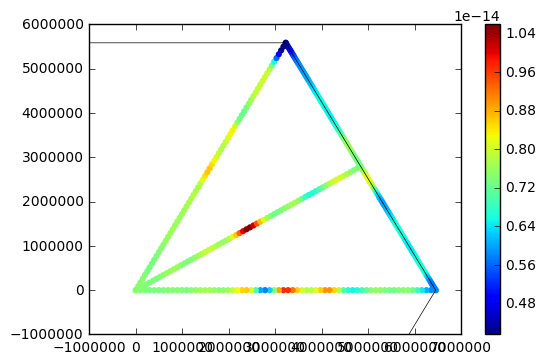

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
f, ax = plt.subplots(1)
sc = ax.scatter(klist[:,0], klist[:,1], c = np.abs(extlist[:]), lw=0)
verts = [(math.cos(math.pi*i/3)*4*np.pi/3/hexside/s3,math.sin(math.pi*i/3)*4*np.pi/3/hexside/s3) for i in range(6 +1)]
codes = [Path.MOVETO,Path.LINETO,Path.LINETO,Path.LINETO,Path.LINETO,Path.LINETO,Path.CLOSEPOLY,]
path = Path(verts, codes)
patch = patches.PathPatch(path, facecolor='none', edgecolor='black',  lw=0.5)
ax.add_patch(patch)
f.colorbar(sc)

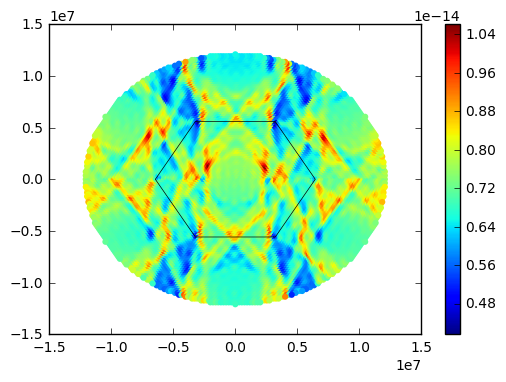

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
f, ax = plt.subplots(1)
sc = ax.scatter(klist[:,0], klist[:,1], c = np.abs(extlist[:]), lw=0)
verts = [(math.cos(math.pi*i/3)*4*np.pi/3/hexside/s3,math.sin(math.pi*i/3)*4*np.pi/3/hexside/s3) for i in range(6 +1)]
codes = [Path.MOVETO,Path.LINETO,Path.LINETO,Path.LINETO,Path.LINETO,Path.LINETO,Path.CLOSEPOLY,]
path = Path(verts, codes)
patch = patches.PathPatch(path, facecolor='none', edgecolor='black',  lw=0.5)
ax.add_patch(patch)
f.colorbar(sc)

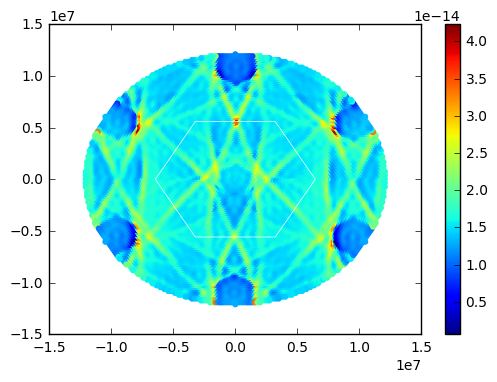

In [273]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
f, ax = plt.subplots(1)
sc = ax.scatter(klist[:,0], klist[:,1], c = np.abs(extlist[:]), lw=0)
verts = [(math.cos(math.pi*i/3)*4*np.pi/3/hexside/s3,math.sin(math.pi*i/3)*4*np.pi/3/hexside/s3) for i in range(6 +1)]
codes = [Path.MOVETO,Path.LINETO,Path.LINETO,Path.LINETO,Path.LINETO,Path.LINETO,Path.CLOSEPOLY,]
path = Path(verts, codes)
patch = patches.PathPatch(path, facecolor='none', edgecolor='white',  lw=0.5)
ax.add_patch(patch)
f.colorbar(sc)

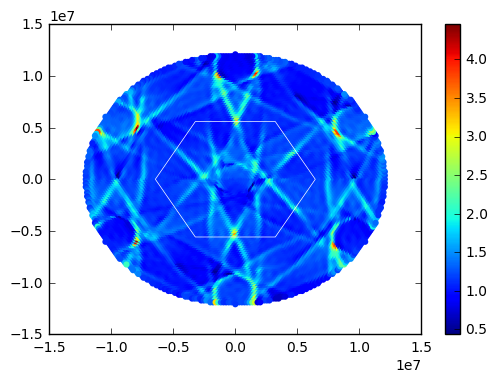

In [270]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
f, ax = plt.subplots(1)
sc = ax.scatter(klist[:,0], klist[:,1], c = np.abs(wlist[:, 0,0,0]), lw=0)
verts = [(math.cos(math.pi*i/3)*4*np.pi/3/hexside/s3,math.sin(math.pi*i/3)*4*np.pi/3/hexside/s3) for i in range(6 +1)]
codes = [Path.MOVETO,Path.LINETO,Path.LINETO,Path.LINETO,Path.LINETO,Path.LINETO,Path.CLOSEPOLY,]
path = Path(verts, codes)
patch = patches.PathPatch(path, facecolor='none', edgecolor='white',  lw=0.5)
ax.add_patch(patch)
f.colorbar(sc)

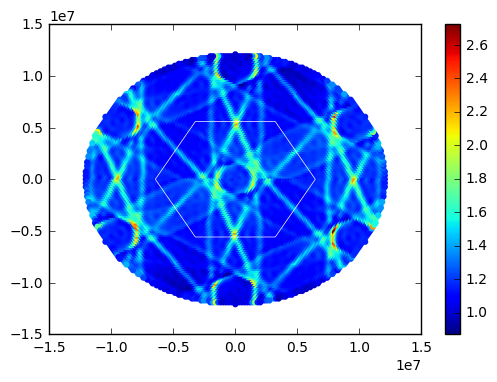

In [271]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
f, ax = plt.subplots(1)
sc = ax.scatter(klist[:,0], klist[:,1], c = np.abs(wlist[:, 1,0,0]), lw=0)
verts = [(math.cos(math.pi*i/3)*4*np.pi/3/hexside/s3,math.sin(math.pi*i/3)*4*np.pi/3/hexside/s3) for i in range(6 +1)]
codes = [Path.MOVETO,Path.LINETO,Path.LINETO,Path.LINETO,Path.LINETO,Path.LINETO,Path.CLOSEPOLY,]
path = Path(verts, codes)
patch = patches.PathPatch(path, facecolor='none', edgecolor='white',  lw=0.5)
ax.add_patch(patch)
f.colorbar(sc)

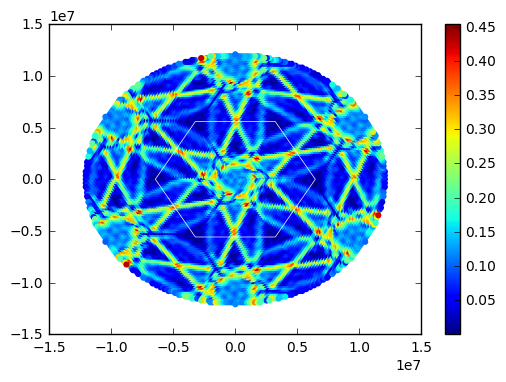

In [234]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
f, ax = plt.subplots(1)
sc = ax.scatter(klist[:,0], klist[:,1], c = np.abs(wlist[:, 1,1,1]), lw=0)
verts = [(math.cos(math.pi*i/3)*4*np.pi/3/hexside/s3,math.sin(math.pi*i/3)*4*np.pi/3/hexside/s3) for i in range(6 +1)]
codes = [Path.MOVETO,Path.LINETO,Path.LINETO,Path.LINETO,Path.LINETO,Path.LINETO,Path.CLOSEPOLY,]
path = Path(verts, codes)
patch = patches.PathPatch(path, facecolor='none', edgecolor='white',  lw=0.5)
ax.add_patch(patch)
f.colorbar(sc)

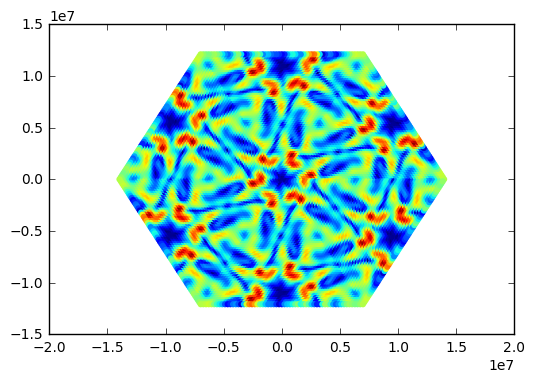

In [163]:
%matplotlib inline
from matplotlib import pyplot as plt
f, ax = plt.subplots(1)
ax.scatter(klist[:,0], klist[:,1], c = np.abs(wlist[:, 0,1,1]), lw=0)

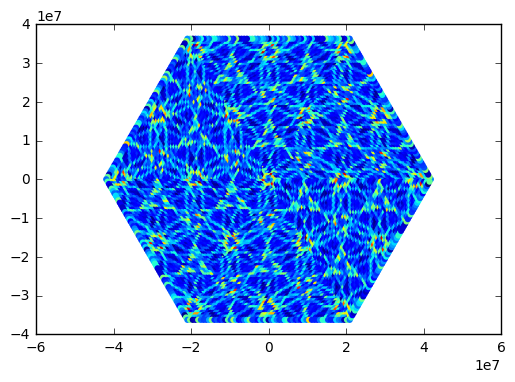

In [124]:


verts = [
    (0., 0.), # left, bottom
    (0., 1.), # left, top
    (1., 1.), # right, top
    (1., 0.), # right, bottom
    (0., 0.), # ignored
    ]

codes = [Path.MOVETO,
         Path.LINETO,
         Path.LINETO,
         Path.LINETO,
         Path.CLOSEPOLY,
         ]

path = Path(verts, codes)

fig = plt.figure()
ax = fig.add_subplot(111)
patch = patches.PathPatch(path, facecolor='orange', lw=2)
ax.add_patch(patch)
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
plt.show()

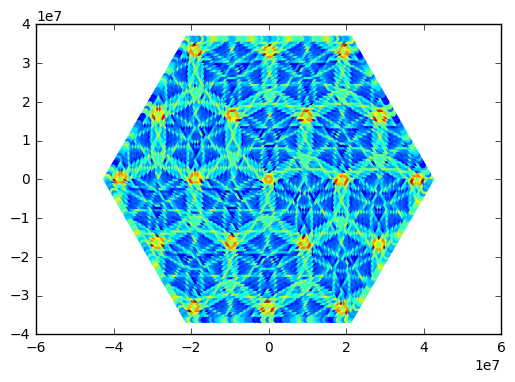

In [112]:
plt.scatter(klist[:,0], klist[:,1], c = np.angle(wlist[:,0,0,8]), lw=0)

In [216]:
np.diag(np.reshape(TMatrices,(2, nelem*2, nelem*2))[0])

array([  3.67397594e-01+0.45352759j,   3.67397594e-01+0.45352759j,
         3.67397594e-01+0.45352759j,   2.47409686e-02+0.12756841j,
         2.47409686e-02+0.12756841j,   2.47409686e-02+0.12756841j,
         2.47409686e-02+0.12756841j,   2.47409686e-02+0.12756841j,
         1.05361865e-03+0.01177466j,   1.05361865e-03+0.01177466j,
         1.05361865e-03+0.01177466j,   1.05361865e-03+0.01177466j,
         1.05361865e-03+0.01177466j,   1.05361865e-03+0.01177466j,
         1.05361865e-03+0.01177466j,   1.84234426e-02+0.11859989j,
         1.84234426e-02+0.11859989j,   1.84234426e-02+0.11859989j,
         5.29277920e-04+0.01055857j,   5.29277920e-04+0.01055857j,
         5.29277920e-04+0.01055857j,   5.29277920e-04+0.01055857j,
         5.29277920e-04+0.01055857j,   1.95305358e-05+0.00045581j,
         1.95305358e-05+0.00045581j,   1.95305358e-05+0.00045581j,
         1.95305358e-05+0.00045581j,   1.95305358e-05+0.00045581j,
         1.95305358e-05+0.00045581j,   1.95305358e-05+0.000455

In [214]:
TMatrices.shape

(2, 2, 15, 2, 15)

In [30]:

kxmaplist = np.concatenate((np.array([0]),np.cumsum(np.linalg.norm(np.diff(klist, axis=0), axis=-1))))

In [34]:
klist.shape

(330, 3)

In [24]:
np.linalg.norm(np.diff(klist, axis=-1), axis=-1).shape

(330,)

In [37]:
k0Mlist = bz_0 + (bz_M-bz_0) * np.linspace(0,1,kdensity)[:,nx]
kMK1list = bz_M + (bz_K1-bz_M) * np.linspace(0,1,kdensity)[:,nx]
kK10list = bz_K1 + (bz_M-bz_K1) * np.linspace(0,1,kdensity)[:,nx]
k0K2list = bz_0 + (bz_K1-bz_0) * np.linspace(0,1,kdensity)[:,nx]
kK2Mlist = bz_K2 + (bz_M-bz_K2) * np.linspace(0,1,kdensity)[:,nx]
klist = np.concatenate((k0Mlist,kMK1list,kK10list,k0K2list,kK2Mlist), axis=0)